# Method 7 - Best Minus Rest Top 3

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns from Intra-Cap Portfolio Weight per Shumway, Szefler, Yuan 2009

%store -r cap_exp_ret

valid_data = valid_data.merge(cap_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)
                                                                                         
# Split Long and Short and Filter to Highest Tilts

long_ideas = valid_data[valid_data['pos_rank'] <= 3].copy()                                                                    
short_ideas = valid_data[valid_data['pos_rank'] > 3].copy()

# Weight the best ideas

long_ideas['target'] = long_ideas['target'] / long_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / long_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

short_ideas['target'] = - short_ideas['target'] / short_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / short_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

best_ideas = pd.concat([long_ideas, short_ideas])

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return.name = 'port_return'

## Plot Performance

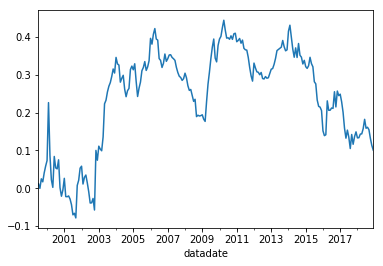

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.058413
2000-12-31   -0.059665
2001-12-31    0.058053
2002-12-31    0.019927
2003-12-31    0.214901
2004-12-31    0.014073
2005-12-31    0.010993
2006-12-31   -0.001452
2007-12-31   -0.034314
2008-12-31   -0.075885
2009-12-31    0.155745
2010-12-31    0.023559
2011-12-31   -0.089868
2012-12-31    0.015490
2013-12-31    0.048200
2014-12-31   -0.020298
2015-12-31   -0.099304
2016-12-31    0.032715
2017-12-31   -0.076977
2018-12-31   -0.042127
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.578
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     78.55
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.54e-42
Time:                        22:30:06   Log-Likelihood:                 614.92
No. Observations:                 234   AIC:                            -1220.
Df Residuals:                     229   BIC:                            -1203.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      1.135      0.257      -0.001       0.004
mktrf         -0.0737      0.033     -2.238      0.026      -0.139      -0.009
me             0.3686      0.038      9.615      0.000       0.293       0.444
ia            -0.0053      0.058     -0.092      0.927      -0.120       0.109
roe           -0.4787      0.050     -9.600      0.000      -0.577      -0.380
==============================================================================
Omnibus:                       98.173   Durbin-Watson:                   2.095
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              779.757
Skew:                           1.425   Prob(JB):                    4.76e-170
Kurtosis:                      11.477   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.578
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     35.13
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.17e-23
Time:                        22:30:06   Log-Likelihood:                 614.92
No. Observations:                 234   AIC:                            -1220.
Df Residuals:                     229   BIC:                            -1203.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      1.044      0.296      -0.001       0.004
mktrf         -0.0737      0.039     -1.893      0.058      -0.150       0.003
me             0.3686      0.061      6.014      0.000       0.248       0.489
ia            -0.0053      0.091     -0.059      0.953      -0.184       0.173
roe           -0.4787      0.107     -4.464      0.000      -0.689      -0.269
==============================================================================
Omnibus:                       98.173   Durbin-Watson:                   2.095
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              779.757
Skew:                           1.425   Prob(JB):                    4.76e-170
Kurtosis:                      11.477   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.578
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     43.95
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.38e-27
Time:                        22:30:06   Log-Likelihood:                 614.92
No. Observations:                 234   AIC:                            -1220.
Df Residuals:                     229   BIC:                            -1203.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      1.014      0.310      -0.001       0.004
mktrf         -0.0737      0.037     -1.970      0.049      -0.147      -0.000
me             0.3686      0.062      5.916      0.000       0.246       0.491
ia            -0.0053      0.093     -0.057      0.954      -0.188       0.178
roe           -0.4787      0.112     -4.289      0.000      -0.697      -0.260
==============================================================================
Omnibus:                       98.173   Durbin-Watson:                   2.095
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              779.757
Skew:                           1.425   Prob(JB):                    4.76e-170
Kurtosis:                      11.477   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                     74.47
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.35e-46
Time:                        22:30:06   Log-Likelihood:                 627.14
No. Observations:                 234   AIC:                            -1242.
Df Residuals:                     228   BIC:                            -1222.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      0.848      0.397      -0.001       0.003
mktrf         -0.0145      0.031     -0.461      0.645      -0.076       0.047
smb            0.3657      0.041      8.825      0.000       0.284       0.447
hml           -0.0856      0.049     -1.753      0.081      -0.182       0.011
rmw           -0.4458      0.055     -8.070      0.000      -0.555      -0.337
cma            0.2138      0.070      3.045      0.003       0.075       0.352
==============================================================================
Omnibus:                      103.461   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              748.743
Skew:                           1.560   Prob(JB):                    2.59e-163
Kurtosis:                      11.189   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                     83.22
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.87e-49
Time:                        22:30:06   Log-Likelihood:                 627.14
No. Observations:                 234   AIC:                            -1242.
Df Residuals:                     228   BIC:                            -1222.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      0.813      0.416      -0.001       0.003
mktrf         -0.0145      0.030     -0.489      0.625      -0.072       0.044
smb            0.3657      0.038      9.623      0.000       0.291       0.440
hml           -0.0856      0.059     -1.452      0.146      -0.201       0.030
rmw           -0.4458      0.090     -4.927      0.000      -0.623      -0.268
cma            0.2138      0.103      2.081      0.037       0.012       0.415
==============================================================================
Omnibus:                      103.461   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              748.743
Skew:                           1.560   Prob(JB):                    2.59e-163
Kurtosis:                      11.189   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                     107.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.02e-58
Time:                        22:30:06   Log-Likelihood:                 627.14
No. Observations:                 234   AIC:                            -1242.
Df Residuals:                     228   BIC:                            -1222.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      0.790      0.430      -0.001       0.003
mktrf         -0.0145      0.031     -0.464      0.643      -0.076       0.047
smb            0.3657      0.037      9.832      0.000       0.293       0.439
hml           -0.0856      0.051     -1.668      0.095      -0.186       0.015
rmw           -0.4458      0.095     -4.705      0.000      -0.632      -0.260
cma            0.2138      0.093      2.298      0.022       0.031       0.396
==============================================================================
Omnibus:                      103.461   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              748.743
Skew:                           1.560   Prob(JB):                    2.59e-163
Kurtosis:                      11.189   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     66.19
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.89e-37
Time:                        22:30:06   Log-Likelihood:                 603.76
No. Observations:                 234   AIC:                            -1198.
Df Residuals:                     229   BIC:                            -1180.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.001     -0.233      0.816      -0.003       0.002
mktrf          0.0270      0.032      0.848      0.397      -0.036       0.090
smb            0.5578      0.040     14.044      0.000       0.480       0.636
hml           -0.0675      0.039     -1.709      0.089      -0.145       0.010
umd           -0.1003      0.026     -3.873      0.000      -0.151      -0.049
==============================================================================
Omnibus:                      130.443   Durbin-Watson:                   2.058
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1674.585
Skew:                           1.865   Prob(JB):                         0.00
Kurtosis:                      15.563   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     28.18
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.80e-19
Time:                        22:30:06   Log-Likelihood:                 603.76
No. Observations:                 234   AIC:                            -1198.
Df Residuals:                     229   BIC:                            -1180.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.001     -0.243      0.808      -0.003       0.002
mktrf          0.0270      0.027      0.984      0.325      -0.027       0.081
smb            0.5578      0.058      9.575      0.000       0.444       0.672
hml           -0.0675      0.041     -1.629      0.103      -0.149       0.014
umd           -0.1003      0.053     -1.890      0.059      -0.204       0.004
==============================================================================
Omnibus:                      130.443   Durbin-Watson:                   2.058
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1674.585
Skew:                           1.865   Prob(JB):                         0.00
Kurtosis:                      15.563   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     35.60
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.04e-23
Time:                        22:30:06   Log-Likelihood:                 603.76
No. Observations:                 234   AIC:                            -1198.
Df Residuals:                     229   BIC:                            -1180.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.001     -0.247      0.805      -0.003       0.002
mktrf          0.0270      0.027      0.990      0.322      -0.026       0.080
smb            0.5578      0.051     10.866      0.000       0.457       0.658
hml           -0.0675      0.038     -1.768      0.077      -0.142       0.007
umd           -0.1003      0.058     -1.744      0.081      -0.213       0.012
==============================================================================
Omnibus:                      130.443   Durbin-Watson:                   2.058
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1674.585
Skew:                           1.865   Prob(JB):                         0.00
Kurtosis:                      15.563   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     38.92
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.44e-20
Time:                        22:30:07   Log-Likelihood:                 290.36
No. Observations:                 120   AIC:                            -570.7
Df Residuals:                     115   BIC:                            -556.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.002      1.084      0.281      -0.002       0.006
mktrf         -0.0550      0.057     -0.970      0.334      -0.167       0.057
me             0.3974      0.056      7.100      0.000       0.287       0.508
ia            -0.0593      0.088     -0.677      0.500      -0.233       0.114
roe           -0.4168      0.078     -5.372      0.000      -0.570      -0.263
==============================================================================
Omnibus:                       59.626   Durbin-Watson:                   2.074
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              353.251
Skew:                           1.550   Prob(JB):                     1.96e-77
Kurtosis:                      10.813   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     35.29
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.28e-19
Time:                        22:30:07   Log-Likelihood:                 290.36
No. Observations:                 120   AIC:                            -570.7
Df Residuals:                     115   BIC:                            -556.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.002      0.977      0.329      -0.002       0.007
mktrf         -0.0550      0.066     -0.833      0.405      -0.184       0.074
me             0.3974      0.081      4.909      0.000       0.239       0.556
ia            -0.0593      0.136     -0.437      0.662      -0.326       0.207
roe           -0.4168      0.162     -2.575      0.010      -0.734      -0.100
==============================================================================
Omnibus:                       59.626   Durbin-Watson:                   2.074
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              353.251
Skew:                           1.550   Prob(JB):                     1.96e-77
Kurtosis:                      10.813   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     53.51
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.15e-25
Time:                        22:30:07   Log-Likelihood:                 290.36
No. Observations:                 120   AIC:                            -570.7
Df Residuals:                     115   BIC:                            -556.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.002      0.924      0.355      -0.003       0.007
mktrf         -0.0550      0.068     -0.812      0.417      -0.188       0.078
me             0.3974      0.086      4.646      0.000       0.230       0.565
ia            -0.0593      0.135     -0.438      0.661      -0.325       0.206
roe           -0.4168      0.168     -2.482      0.013      -0.746      -0.088
==============================================================================
Omnibus:                       59.626   Durbin-Watson:                   2.074
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              353.251
Skew:                           1.550   Prob(JB):                     1.96e-77
Kurtosis:                      10.813   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     46.16
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.44e-26
Time:                        22:30:07   Log-Likelihood:                 305.41
No. Observations:                 120   AIC:                            -598.8
Df Residuals:                     114   BIC:                            -582.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.002      1.499      0.137      -0.001       0.007
mktrf          0.0097      0.053      0.184      0.854      -0.095       0.115
smb            0.3639      0.060      6.068      0.000       0.245       0.483
hml           -0.1256      0.073     -1.709      0.090      -0.271       0.020
rmw           -0.4202      0.087     -4.849      0.000      -0.592      -0.249
cma            0.2274      0.095      2.396      0.018       0.039       0.415
==============================================================================
Omnibus:                       58.878   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              325.690
Skew:                           1.555   Prob(JB):                     1.89e-71
Kurtosis:                      10.448   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     72.58
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.37e-34
Time:                        22:30:07   Log-Likelihood:                 305.41
No. Observations:                 120   AIC:                            -598.8
Df Residuals:                     114   BIC:                            -582.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.002      1.451      0.147      -0.001       0.007
mktrf          0.0097      0.044      0.219      0.827      -0.077       0.097
smb            0.3639      0.057      6.363      0.000       0.252       0.476
hml           -0.1256      0.086     -1.457      0.145      -0.295       0.043
rmw           -0.4202      0.141     -2.979      0.003      -0.697      -0.144
cma            0.2274      0.116      1.965      0.049       0.001       0.454
==============================================================================
Omnibus:                       58.878   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              325.690
Skew:                           1.555   Prob(JB):                     1.89e-71
Kurtosis:                      10.448   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     102.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.66e-40
Time:                        22:30:07   Log-Likelihood:                 305.41
No. Observations:                 120   AIC:                            -598.8
Df Residuals:                     114   BIC:                            -582.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.002      1.356      0.175      -0.001       0.007
mktrf          0.0097      0.045      0.217      0.828      -0.078       0.098
smb            0.3639      0.060      6.073      0.000       0.246       0.481
hml           -0.1256      0.076     -1.661      0.097      -0.274       0.023
rmw           -0.4202      0.148     -2.843      0.004      -0.710      -0.130
cma            0.2274      0.094      2.415      0.016       0.043       0.412
==============================================================================
Omnibus:                       58.878   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              325.690
Skew:                           1.555   Prob(JB):                     1.89e-71
Kurtosis:                      10.448   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     42.23
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.54e-22
Time:                        22:30:07   Log-Likelihood:                 293.23
No. Observations:                 120   AIC:                            -576.5
Df Residuals:                     115   BIC:                            -562.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.002      0.556      0.579      -0.003       0.005
mktrf          0.0650      0.049      1.334      0.185      -0.032       0.162
smb            0.5561      0.056     10.020      0.000       0.446       0.666
hml           -0.1095      0.056     -1.970      0.051      -0.220       0.001
umd           -0.0777      0.034     -2.268      0.025      -0.146      -0.010
==============================================================================
Omnibus:                       83.077   Durbin-Watson:                   2.163
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              873.812
Skew:                           2.113   Prob(JB):                    1.80e-190
Kurtosis:                      15.526   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     69.17
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.04e-29
Time:                        22:30:07   Log-Likelihood:                 293.23
No. Observations:                 120   AIC:                            -576.5
Df Residuals:                     115   BIC:                            -562.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.002      0.658      0.510      -0.002       0.004
mktrf          0.0650      0.033      1.991      0.046       0.001       0.129
smb            0.5561      0.071      7.832      0.000       0.417       0.695
hml           -0.1095      0.053     -2.085      0.037      -0.212      -0.007
umd           -0.0777      0.061     -1.266      0.206      -0.198       0.043
==============================================================================
Omnibus:                       83.077   Durbin-Watson:                   2.163
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              873.812
Skew:                           2.113   Prob(JB):                    1.80e-190
Kurtosis:                      15.526   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     124.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.40e-41
Time:                        22:30:07   Log-Likelihood:                 293.23
No. Observations:                 120   AIC:                            -576.5
Df Residuals:                     115   BIC:                            -562.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.002      0.659      0.510      -0.002       0.004
mktrf          0.0650      0.031      2.066      0.039       0.003       0.127
smb            0.5561      0.064      8.689      0.000       0.431       0.682
hml           -0.1095      0.050     -2.184      0.029      -0.208      -0.011
umd           -0.0777      0.064     -1.216      0.224      -0.203       0.048
==============================================================================
Omnibus:                       83.077   Durbin-Watson:                   2.163
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              873.812
Skew:                           2.113   Prob(JB):                    1.80e-190
Kurtosis:                      15.526   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     46.58
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.09e-23
Time:                        22:30:07   Log-Likelihood:                 351.83
No. Observations:                 114   AIC:                            -693.7
Df Residuals:                     109   BIC:                            -680.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.216      0.829      -0.002       0.002
mktrf         -0.0591      0.033     -1.779      0.078      -0.125       0.007
me             0.2583      0.051      5.035      0.000       0.157       0.360
ia             0.0809      0.071      1.136      0.258      -0.060       0.222
roe           -0.6153      0.063     -9.839      0.000      -0.739      -0.491
==============================================================================
Omnibus:                       14.459   Durbin-Watson:                   2.099
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.632
Skew:                           0.717   Prob(JB):                     0.000148
Kurtosis:                       4.287   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     56.21
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.21e-25
Time:                        22:30:07   Log-Likelihood:                 351.83
No. Observations:                 114   AIC:                            -693.7
Df Residuals:                     109   BIC:                            -680.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.321      0.748      -0.001       0.002
mktrf         -0.0591      0.026     -2.284      0.022      -0.110      -0.008
me             0.2583      0.045      5.791      0.000       0.171       0.346
ia             0.0809      0.099      0.815      0.415      -0.114       0.275
roe           -0.6153      0.088     -6.990      0.000      -0.788      -0.443
==============================================================================
Omnibus:                       14.459   Durbin-Watson:                   2.099
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.632
Skew:                           0.717   Prob(JB):                     0.000148
Kurtosis:                       4.287   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     89.40
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.63e-33
Time:                        22:30:07   Log-Likelihood:                 351.83
No. Observations:                 114   AIC:                            -693.7
Df Residuals:                     109   BIC:                            -680.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.401      0.688      -0.001       0.001
mktrf         -0.0591      0.021     -2.763      0.006      -0.101      -0.017
me             0.2583      0.047      5.452      0.000       0.165       0.351
ia             0.0809      0.113      0.714      0.475      -0.141       0.303
roe           -0.6153      0.086     -7.187      0.000      -0.783      -0.447
==============================================================================
Omnibus:                       14.459   Durbin-Watson:                   2.099
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.632
Skew:                           0.717   Prob(JB):                     0.000148
Kurtosis:                       4.287   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     19.58
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.73e-14
Time:                        22:30:07   Log-Likelihood:                 331.79
No. Observations:                 114   AIC:                            -651.6
Df Residuals:                     108   BIC:                            -635.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.001     -0.671      0.503      -0.004       0.002
mktrf         -0.0194      0.038     -0.510      0.611      -0.095       0.056
smb            0.3515      0.062      5.705      0.000       0.229       0.474
hml           -0.0055      0.079     -0.070      0.944      -0.161       0.150
rmw           -0.3999      0.096     -4.155      0.000      -0.591      -0.209
cma            0.1829      0.122      1.497      0.137      -0.059       0.425
==============================================================================
Omnibus:                       29.601   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               71.314
Skew:                           0.972   Prob(JB):                     3.27e-16
Kurtosis:                       6.351   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     27.45
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.74e-18
Time:                        22:30:07   Log-Likelihood:                 331.79
No. Observations:                 114   AIC:                            -651.6
Df Residuals:                     108   BIC:                            -635.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.001     -0.768      0.442      -0.003       0.001
mktrf         -0.0194      0.041     -0.474      0.635      -0.099       0.061
smb            0.3515      0.045      7.893      0.000       0.264       0.439
hml           -0.0055      0.063     -0.087      0.931      -0.129       0.118
rmw           -0.3999      0.144     -2.772      0.006      -0.683      -0.117
cma            0.1829      0.125      1.458      0.145      -0.063       0.429
==============================================================================
Omnibus:                       29.601   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               71.314
Skew:                           0.972   Prob(JB):                     3.27e-16
Kurtosis:                       6.351   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     38.34
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.86e-22
Time:                        22:30:07   Log-Likelihood:                 331.79
No. Observations:                 114   AIC:                            -651.6
Df Residuals:                     108   BIC:                            -635.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.001     -0.989      0.323      -0.003       0.001
mktrf         -0.0194      0.043     -0.452      0.651      -0.103       0.065
smb            0.3515      0.048      7.370      0.000       0.258       0.445
hml           -0.0055      0.062     -0.088      0.930      -0.128       0.117
rmw           -0.3999      0.150     -2.658      0.008      -0.695      -0.105
cma            0.1829      0.151      1.212      0.226      -0.113       0.479
==============================================================================
Omnibus:                       29.601   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               71.314
Skew:                           0.972   Prob(JB):                     3.27e-16
Kurtosis:                       6.351   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.407
Method:                 Least Squares   F-statistic:                     20.37
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.50e-12
Time:                        22:30:07   Log-Likelihood:                 326.83
No. Observations:                 114   AIC:                            -643.7
Df Residuals:                     109   BIC:                            -630.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.001     -0.678      0.499      -0.004       0.002
mktrf         -0.0120      0.039     -0.305      0.761      -0.090       0.066
smb            0.4450      0.061      7.279      0.000       0.324       0.566
hml            0.0842      0.063      1.338      0.184      -0.041       0.209
umd           -0.1411      0.048     -2.971      0.004      -0.235      -0.047
==============================================================================
Omnibus:                       30.484   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              104.700
Skew:                           0.852   Prob(JB):                     1.84e-23
Kurtosis:                       7.375   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.407
Method:                 Least Squares   F-statistic:                     30.77
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.87e-17
Time:                        22:30:07   Log-Likelihood:                 326.83
No. Observations:                 114   AIC:                            -643.7
Df Residuals:                     109   BIC:                            -630.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.001     -0.817      0.414      -0.003       0.001
mktrf         -0.0120      0.043     -0.279      0.781      -0.096       0.072
smb            0.4450      0.054      8.225      0.000       0.339       0.551
hml            0.0842      0.063      1.345      0.179      -0.039       0.207
umd           -0.1411      0.034     -4.100      0.000      -0.209      -0.074
==============================================================================
Omnibus:                       30.484   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              104.700
Skew:                           0.852   Prob(JB):                     1.84e-23
Kurtosis:                       7.375   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.407
Method:                 Least Squares   F-statistic:                     39.72
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.73e-20
Time:                        22:30:07   Log-Likelihood:                 326.83
No. Observations:                 114   AIC:                            -643.7
Df Residuals:                     109   BIC:                            -630.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.001     -0.916      0.360      -0.003       0.001
mktrf         -0.0120      0.043     -0.281      0.779      -0.095       0.072
smb            0.4450      0.044     10.161      0.000       0.359       0.531
hml            0.0842      0.059      1.420      0.156      -0.032       0.200
umd           -0.1411      0.030     -4.711      0.000      -0.200      -0.082
==============================================================================
Omnibus:                       30.484   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              104.700
Skew:                           0.852   Prob(JB):                     1.84e-23
Kurtosis:                       7.375   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""